In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 

In [6]:
Batch_size=256
Buffer_size=60000

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(Buffer_size).batch(Batch_size)

In [8]:
learning_rate=0.002
epochs=30
image_dim=784
gen_hid_dim=256
dis_hid_dim=256
z_noise_dim=101

In [9]:
def xavier_init(shape):
    return tf.random.normal(shape=shape,stddev=1./tf.sqrt(shape[0]/2))

In [10]:
disc_H=tf.Variable(xavier_init([image_dim,dis_hid_dim]))#weights
disc_final=tf.Variable(xavier_init([dis_hid_dim,1]))
gen_H=tf.Variable(xavier_init([z_noise_dim,gen_hid_dim]))
gen_final=tf.Variable(xavier_init([gen_hid_dim,image_dim]))

In [11]:
disc_H_b=tf.Variable(xavier_init([dis_hid_dim]))
disc_final_b=tf.Variable(xavier_init([1]))
gen_H_b=tf.Variable(xavier_init([gen_hid_dim]))
gen_final_b=tf.Variable(xavier_init([image_dim]))

In [12]:
def discriminator(x):
    hidden_layer=tf.nn.relu(tf.add(tf.matmul(x,disc_H),disc_H_b))
    final_layer=tf.add(tf.matmul(hidden_layer,disc_final),disc_final_b)
    output_layer=tf.nn.sigmoid(final_layer)
    return final_layer,output_layer

In [13]:
def generator(x):
    hidden_layer=tf.nn.relu(tf.add(tf.matmul(x,gen_H),gen_H_b))
    final_layer=tf.add(tf.matmul(hidden_layer,gen_final),gen_final_b)
    output_layer=tf.nn.tanh(final_layer)
    return output_layer

In [51]:
from tensorflow.keras import layers

In [53]:
def discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [48]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(101,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

In [54]:
generator=generator_model()
discriminator=discriminator_model()

In [14]:
noise = tf.random.normal([1, 101])

In [15]:
out=generator(noise)

In [16]:
from tensorflow.keras.preprocessing.image import array_to_img

In [17]:
for x in train_dataset:
    print(x.shape)
    img=array_to_img(x[1].numpy())
    img.show()
    break

(256, 28, 28, 1)


In [18]:
random_img=array_to_img(out.numpy().reshape(28,28,1))
random_img.show()

In [19]:
_,r=discriminator(out)
r

<tf.Tensor: id=167, shape=(1, 1), dtype=float32, numpy=array([[0.9847296]], dtype=float32)>

In [65]:
def discriminator_loss(real_output_disc,fake_output_disc):
    disc_real_loss=-tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output_disc,labels=tf.ones_like(real_output_disc)))
    disc_fake_loss=-tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output_disc,labels=tf.zeros_like(fake_output_disc)))
    total_loss=disc_real_loss+disc_fake_loss
    return total_loss

In [66]:
def generator_loss(fake_output_disc):
    disc_fake_loss=-tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output_disc,labels=tf.ones_like(fake_output_disc)))
    return disc_fake_loss

In [23]:
disc_real_loss_summary=tf.summary.scalar("disc_real_loss",disc_real_loss)
disc_fake_loss_summary=tf.summary.scalar("disc_fake_loss",disc_fake_loss)
disc_total_loss_summary=tf.summary.scalar("disc_total_loss",disc_total_loss)
gen_fake_loss_summary=tf.summary.scalar("gen_fake_loss",gen_fake_loss)

NameError: name 'disc_real_loss' is not defined

In [25]:
discriminator_optimizer=tf.keras.optimizers.Adam(lr=learning_rate)
generator_optimizer=tf.keras.optimizers.Adam(lr=learning_rate)

In [27]:
import os

In [55]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [73]:
@tf.function
def train_step(images):
    noise=tf.random.normal([Batch_size,z_noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images=generator(noise,training=True)
        real_output=discriminator(images,training=True)
        
        fake_output=discriminator(generated_images,training=True)
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
        
    grad_of_gen=gen_tape.gradient(gen_loss,generator.trainable_variables)
    grad_of_disc=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_of_gen,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_of_disc,discriminator.trainable_variables))

In [41]:
from IPython import display
import time

In [42]:
num_ex_to_gen=16

In [43]:
seed = tf.random.normal([num_ex_to_gen, z_noise_dim])

In [77]:
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()
        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        if (epoch + 1) % 15 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch,seed)

In [78]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

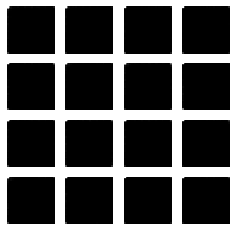

Time for epoch 8 is 401.1710114479065 sec


In [ ]:
train(train_dataset, epochs)